In [2]:
import itertools
import time
from dataclasses import asdict, astuple, dataclass
from functools import partial
from typing import Any

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import seaborn as sns
from common import EXPORT_DPI, OUTPUT_DIR, PAPER_WIDTH_IN, setup_plotting
from jk_utils import (
    construct_vandermonde,
    grad_jacobi_polynomial,
    jacobi_gauss_lobatto,
    jacobi_polynomial,
)

%load_ext autoreload
%autoreload 2

In [3]:
setup_plotting()

# 2.h
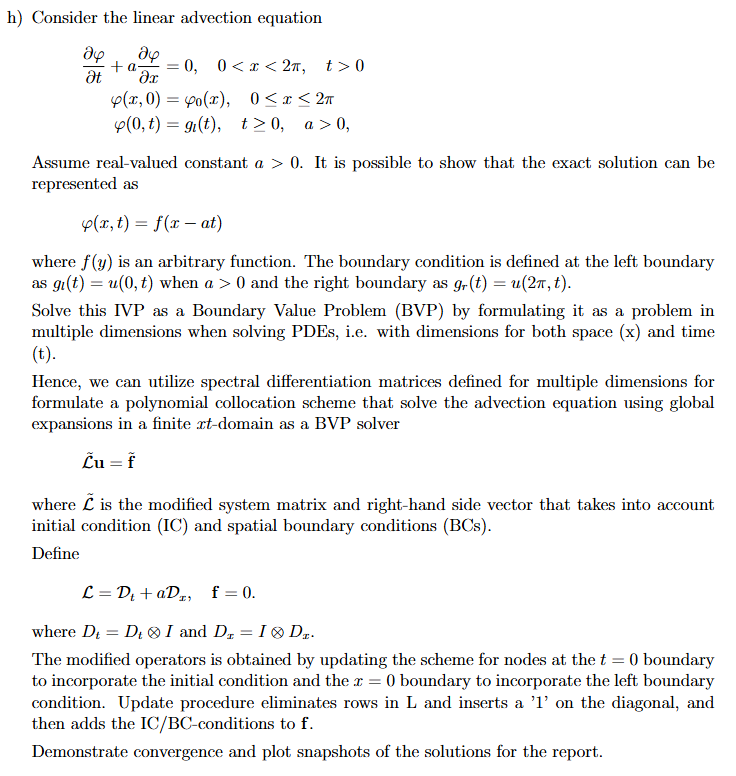

In [4]:
# x = np.linspace(0, 2*np.pi, 1000)
# plt.plot(x, phi(x, t=0.0, a=0.1, c=1.0, x_0=np.pi))

<Figure size 640x480 with 0 Axes>

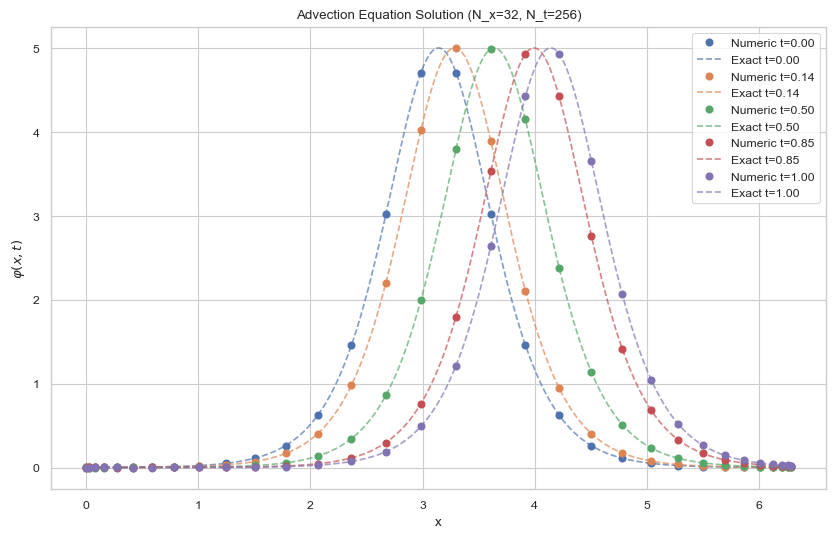

In [5]:
# Function to solve
# Lets just use travelling wave similar to before
def soliton(
    x: npt.NDArray[np.float64], c: float, x_0: float
) -> npt.NDArray[np.float64]:
    sech_argument = np.sqrt(c) * (x - x_0) / 2.0
    f = 1 / 2 * c * (1 / np.cosh(sech_argument)) ** 2

    return f

def phi(x, t, a, c, x_0):
    x_prime = x - a * t
    return soliton(x_prime, c=c, x_0=x_0)

# Solver parameters
alpha_x = 0.0
beta_x = 0.0
alpha_t = 0.0
beta_t = 0.0

# Domain
x_l = 0
x_r = 2 * np.pi
t_0 = 0.0
t_final = 1.0

# Discretisation Parameters
# N_x_grid = 5
# N_t_grid = 5
N_x_grid = 32
N_t_grid = 256
N_x = N_x_grid - 1  # Polynomial degree
N_t = N_t_grid - 1  # Polynomial degree

# x = np.linspace(x_l, x_r, N_x_grid, endpoint=True)
# t = np.linspace(t_0, t_final, N_t_grid, endpoint=True)
x = jacobi_gauss_lobatto(N_x, alpha_x, beta_x)[0] * (x_r - x_l) / 2 + (x_r + x_l) / 2
t = jacobi_gauss_lobatto(N_t, alpha_t, beta_t)[0] * (t_final - t_0) / 2 + (t_final + t_0) / 2

# Map to canonical domain [-1, 1]
z_x = 2 * (x - x_l) / (x_r - x_l) - 1
z_t = 2 * (t - t_0) / (t_final - t_0) - 1

# Problem parameters
a = 1.0  # Advection speed, a > 0
c = 10.0  # Soliton speed
x_0 = 1.0 * np.pi


# Set up basis functions
basis_func_x = partial(jacobi_polynomial, alpha=alpha_x, beta=beta_x)
basis_func_x_grad = partial(grad_jacobi_polynomial, alpha=alpha_x, beta=beta_x)
basis_func_t = partial(jacobi_polynomial, alpha=alpha_t, beta=beta_t)
basis_func_t_grad = partial(grad_jacobi_polynomial, alpha=alpha_t, beta=beta_t)

# Set up differentiation matrices
V_x = construct_vandermonde(z_x, N_x_grid, basis_func_x)
V_x_grad = construct_vandermonde(z_x, N_x_grid, basis_func_x_grad)
D_x_canonical = np.linalg.solve(V_x.T, V_x_grad.T).T  # D_x = V_x_grad * V_x^{-1}, right solve

V_t = construct_vandermonde(z_t, N_t_grid, basis_func_t)
V_t_grad = construct_vandermonde(z_t, N_t_grid, basis_func_t_grad)
D_t_canonical = np.linalg.solve(V_t.T, V_t_grad.T).T  # D_t = V_t_grad * V_t^{-1}, right solve

# Scale differentiation matrices to physical domain
D_x = 2 / (x_r - x_l) * D_x_canonical
D_t = 2 / (t_final - t_0) * D_t_canonical

I_x = np.eye(N_x_grid)
I_t = np.eye(N_t_grid)

D_t_full = np.kron(D_t, I_x)
D_x_full = np.kron(I_t, D_x)

L_n = D_t_full + a * D_x_full
f_n = np.zeros(N_x_grid * N_t_grid)

# Apply boundary and initial conditions
L_n_hat = L_n.copy()
f_n_hat = f_n.copy()

# Apply initial condition at t=0
ic_indices = np.arange(N_x_grid)
L_n_hat[ic_indices, :] = 0.0
L_n_hat[ic_indices, ic_indices] = 1.0
f_n_hat[ic_indices] = phi(x, t=t[0], a=a, c=c, x_0=x_0)

# Apply boundary condition at x=0
bc_indices = np.arange(1, N_t_grid) * N_x_grid
L_n_hat[bc_indices, :] = 0.0
L_n_hat[bc_indices, bc_indices] = 1.0
f_n_hat[bc_indices] = phi(x=x[0], t=t[1:], a=a, c=c, x_0=x_0)

# Solve
u_flat = np.linalg.solve(L_n_hat, f_n_hat)
u_numeric = u_flat.reshape((N_t_grid, N_x_grid))

# Plot solution
X, T = np.meshgrid(x, t)
u_exact = phi(X, T, a=a, c=c, x_0=x_0)

plt.figure()
fig, ax = plt.subplots(figsize=(10, 6))
plot_time_indices = np.linspace(0, N_t_grid - 1, 5, dtype=int)
x_fine = np.linspace(x_l, x_r, 1000)
for k in plot_time_indices:
    t_k = t[k]
    u_exact_fine = phi(x_fine, t=t_k, a=a, c=c, x_0=x_0)
    line = ax.plot(x, u_numeric[k, :], 'o', label=f'Numeric t={t_k:.2f}')
    ax.plot(x_fine, u_exact_fine, '--', label=f'Exact t={t_k:.2f}', alpha=0.7, color=line[0].get_color())

ax.set_title(f"Advection Equation Solution (N_x={N_x_grid}, N_t={N_t_grid})")
ax.set_xlabel("x")
ax.set_ylabel("$φ(x,t)$")
ax.legend()
ax.grid(True)
plt.show()



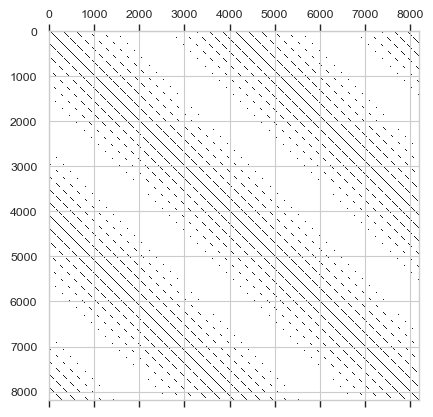

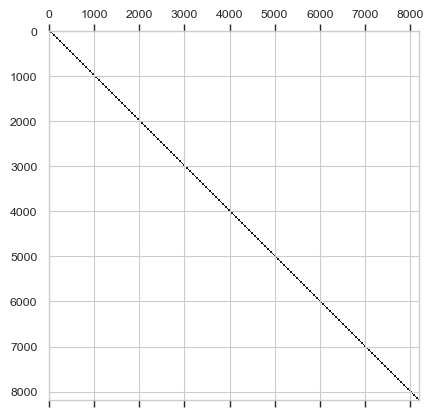

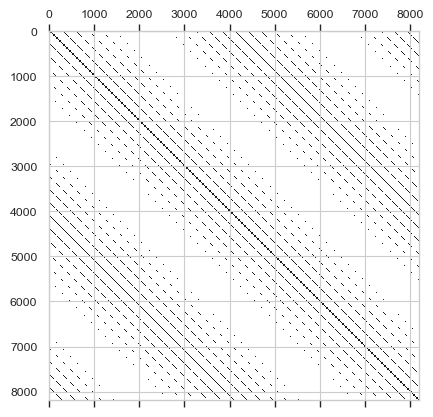

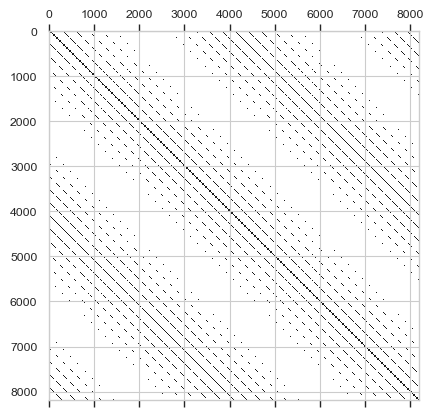

In [6]:
plt.figure()
plt.spy(D_t_full)

plt.figure()
plt.spy(D_x_full)

plt.figure()
plt.spy(L_n)

plt.figure()
plt.spy(L_n_hat)

In [8]:
# Test convergence
# Solver parameters
alpha_x = 0.0
beta_x = 0.0
alpha_t = 0.0
beta_t = 0.0

# Domain
x_l = 0
x_r = 2 * np.pi
t_0 = 0.0
t_final = 1.0

# N_x_grids = np.arange(4, 128, 2)
# N_t_grids = np.arange(4, 128, 2)

# N_grids = np.concatenate(
#     [
#         np.array([(16, N_x) for N_x in N_x_grids]),
#         np.array([(N_t, 64) for N_t in N_t_grids]),
#     ],
# )
N_x_grids = np.arange(4, 128, 4, dtype=int)
N_t_grids = np.geomspace(4, 64, num=8, dtype=int)

N_grids = itertools.product(N_x_grids, N_t_grids)
data = []
for N_x_grid, N_t_grid in N_grids:
    print(f"Solving for N_x={N_x_grid}, N_t={N_t_grid}")
    N_x = N_x_grid - 1  # Polynomial degree
    N_t = N_t_grid - 1  # Polynomial degree

    # x = np.linspace(x_l, x_r, N_x_grid, endpoint=True)
    # t = np.linspace(t_0, t_final, N_t_grid, endpoint=True)
    x = jacobi_gauss_lobatto(N_x, alpha_x, beta_x)[0] * (x_r - x_l) / 2 + (x_r + x_l) / 2
    t = jacobi_gauss_lobatto(N_t, alpha_t, beta_t)[0] * (t_final - t_0) / 2 + (t_final + t_0) / 2

    # Map to canonical domain [-1, 1]
    z_x = 2 * (x - x_l) / (x_r - x_l) - 1
    z_t = 2 * (t - t_0) / (t_final - t_0) - 1

    # Problem parameters
    a = 1.0  # Advection speed, a > 0
    c = 10.0  # Soliton speed
    x_0 = 1.0 * np.pi


    # Set up basis functions
    basis_func_x = partial(jacobi_polynomial, alpha=alpha_x, beta=beta_x)
    basis_func_x_grad = partial(grad_jacobi_polynomial, alpha=alpha_x, beta=beta_x)
    basis_func_t = partial(jacobi_polynomial, alpha=alpha_t, beta=beta_t)
    basis_func_t_grad = partial(grad_jacobi_polynomial, alpha=alpha_t, beta=beta_t)

    # Set up differentiation matrices
    V_x = construct_vandermonde(z_x, N_x_grid, basis_func_x)
    V_x_grad = construct_vandermonde(z_x, N_x_grid, basis_func_x_grad)
    D_x_canonical = np.linalg.solve(V_x.T, V_x_grad.T).T  # D_x = V_x_grad * V_x^{-1}, right solve

    V_t = construct_vandermonde(z_t, N_t_grid, basis_func_t)
    V_t_grad = construct_vandermonde(z_t, N_t_grid, basis_func_t_grad)
    D_t_canonical = np.linalg.solve(V_t.T, V_t_grad.T).T  # D_t = V_t_grad * V_t^{-1}, right solve

    # Scale differentiation matrices to physical domain
    D_x = 2 / (x_r - x_l) * D_x_canonical
    D_t = 2 / (t_final - t_0) * D_t_canonical

    I_x = np.eye(N_x_grid)
    I_t = np.eye(N_t_grid)

    D_t_full = np.kron(D_t, I_x)
    D_x_full = np.kron(I_t, D_x)

    L_n = D_t_full + a * D_x_full
    f_n = np.zeros(N_x_grid * N_t_grid)

    # Apply boundary and initial conditions
    L_n_hat = L_n.copy()
    f_n_hat = f_n.copy()

    # Apply initial condition at t=0
    ic_indices = np.arange(N_x_grid)
    L_n_hat[ic_indices, :] = 0.0
    L_n_hat[ic_indices, ic_indices] = 1.0
    f_n_hat[ic_indices] = phi(x, t=t[0], a=a, c=c, x_0=x_0)

    # Apply boundary condition at x=0
    bc_indices = np.arange(1, N_t_grid) * N_x_grid
    L_n_hat[bc_indices, :] = 0.0
    L_n_hat[bc_indices, bc_indices] = 1.0
    f_n_hat[bc_indices] = phi(x=x[0], t=t[1:], a=a, c=c, x_0=x_0)

    # Solve
    u_flat = np.linalg.solve(L_n_hat, f_n_hat)
    u_numeric = u_flat.reshape((N_t_grid, N_x_grid))

    # Plot solution
    X, T = np.meshgrid(x, t)
    u_exact = phi(X, T, a=a, c=c, x_0=x_0)

    error = u_numeric - u_exact
    error_L2 = np.linalg.norm(error) / np.linalg.norm(u_exact)
    error_L_inf = np.linalg.norm(error, np.inf) / np.linalg.norm(u_exact, np.inf)
    data.append(
        {
            "N_x_grid": N_x_grid,
            "N_t_grid": N_t_grid,
            "error_L2": error_L2,
            "error_L_inf": error_L_inf,
        }
    )


Solving for N_x=4, N_t=4
Solving for N_x=4, N_t=5
Solving for N_x=4, N_t=8
Solving for N_x=4, N_t=13
Solving for N_x=4, N_t=19
Solving for N_x=4, N_t=28
Solving for N_x=4, N_t=43
Solving for N_x=4, N_t=64
Solving for N_x=8, N_t=4
Solving for N_x=8, N_t=5
Solving for N_x=8, N_t=8
Solving for N_x=8, N_t=13
Solving for N_x=8, N_t=19
Solving for N_x=8, N_t=28
Solving for N_x=8, N_t=43
Solving for N_x=8, N_t=64
Solving for N_x=12, N_t=4
Solving for N_x=12, N_t=5
Solving for N_x=12, N_t=8
Solving for N_x=12, N_t=13
Solving for N_x=12, N_t=19
Solving for N_x=12, N_t=28
Solving for N_x=12, N_t=43
Solving for N_x=12, N_t=64
Solving for N_x=16, N_t=4
Solving for N_x=16, N_t=5
Solving for N_x=16, N_t=8
Solving for N_x=16, N_t=13
Solving for N_x=16, N_t=19
Solving for N_x=16, N_t=28
Solving for N_x=16, N_t=43
Solving for N_x=16, N_t=64
Solving for N_x=20, N_t=4
Solving for N_x=20, N_t=5
Solving for N_x=20, N_t=8
Solving for N_x=20, N_t=13
Solving for N_x=20, N_t=19
Solving for N_x=20, N_t=28
Solvi

[]

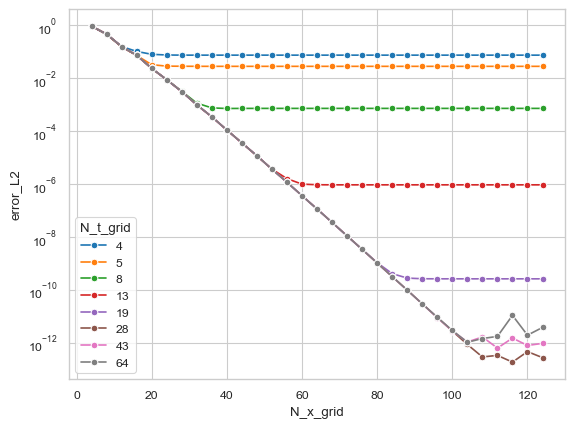

In [14]:
df = pd.DataFrame(data)

sns.lineplot(df, x="N_x_grid", y="error_L2", hue="N_t_grid", marker="o", palette="tab10")
plt.semilogy()